# Loyalty Program Analysis in Retail Company

Home World is a company engaged in the retail of building materials. Each customer has a membership card, where to join the loyalty program you can subscribe for $20/month. The program includes discounts, special offers, and gifts. As data analysts we have the task to check how effective the loyalty program is. We have to answer a few questions:

- Is the average purchase for loyalty program users higher than for non-loyalty program users?
- Is the purchase frequency for loyalty program users higher than for non-loyalty program users?
- Test the hypothesis that the average purchase size is higher for loyalty program members than non-members.

**Dataset Description**
There are 2 datasets namely retail_dataset_us.csv and product_codes_us.csv. This dataset includes the following columns:

Dataset retail_dataset.csv:

purchaseId — A unique identification number for each purchase transaction.

item_ID — A unique identification number for each item purchased in a transaction.

purchasedate — The date and time the purchase transaction was made.

Quantity — The number of items purchased in one transaction.

CustomerID — A unique identification number for each customer.

ShopID — A unique identification number for each retail store.

loyalty_program — Indicates whether the customer is a member of the loyalty program or not.


Dataset new_product_codes.csv:

productID — A unique identification number for each product.

price_per_one — Price per unit (units) of the product.

In [1208]:
# import all nessesary libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from scipy import stats as st
import math as mth
import datetime as dt
import plotly.express as px
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

In [1209]:
# load the data
retail = pd.read_csv('retail_dataset.csv', parse_dates = ['purchasedate'])
retail.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [1210]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchaseid       105335 non-null  object        
 1   item_ID          105335 non-null  object        
 2   Quantity         105335 non-null  int64         
 3   purchasedate     105335 non-null  datetime64[ns]
 4   CustomerID       69125 non-null   float64       
 5   ShopID           105335 non-null  object        
 6   loyalty_program  105335 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.6+ MB


From the information above, we know that there are 105335 rows and 7 columns. Where we can see that the CustomerID column has a missing value.

In [1211]:
products = pd.read_csv('new_product_codes.csv')
products.head()

,productID,price_per_one
0,10002,1.66
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


In [1212]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      3159 non-null   object 
 1   price_per_one  3159 non-null   float64
dtypes: float64(1), object(1)
memory usage: 49.5+ KB


From the information above, we know that there are 3159 rows and 2 columns, where there are no missing values in this dataset.

## Preprocessing Data

In [1213]:
# Remove duplicate values
print('Number of duplicated rows in Products: ', products.duplicated().sum())
print('Number of duplicated rows in Retail: ', retail.duplicated().sum())

Number of duplicated rows in Products:  0
Number of duplicated rows in Retail:  1033


In [1214]:
# Find percent of duplicates
len_data= len(retail)
total_duplicates= retail.duplicated().sum()
percentage_duplicates= (total_duplicates/ len_data)* 100
percentage_duplicates

0.9806806854321926

The total duplicate values in the Retail dataset is 0.98%, this value is not too big and we decided to delete duplicated values.

In [1215]:
retail.drop_duplicates(inplace = True)
print('Number of duplicated rows in Retail: ', retail.duplicated().sum())

Number of duplicated rows in Retail:  0


No more duplicate values were found in the retail dataset.

In [1216]:
# handle missing values
products.isnull().sum()

productID        0
price_per_one    0
dtype: int64

There are no empty values in the Product dataset.

In [1217]:
retail.isnull().sum()

purchaseid             0
item_ID                0
Quantity               0
purchasedate           0
CustomerID         36148
ShopID                 0
loyalty_program        0
dtype: int64

In [1218]:
missing_percentage= retail.isna().mean()* 100
missing_percentage

purchaseid          0.000000
item_ID             0.000000
Quantity            0.000000
purchasedate        0.000000
CustomerID         34.657054
ShopID              0.000000
loyalty_program     0.000000
dtype: float64

There are about 34% missing values in the CustomerID column. The amount of data is too much to do the deletion process.

In [1219]:
null_customers = retail.loc[retail['CustomerID'].isnull()]
null_customers.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
11,541696,22197,4,2017-01-20 18:08:00,NaN,Shop 0,0.0
16,539744,22300,5,2016-12-21 15:21:00,NaN,Shop 0,0.0


In [1220]:
null_customers['loyalty_program'].unique()

array([0.])

In [1221]:
null_customers['ShopID'].unique()

array(['Shop 0', 'Shop 25', 'Shop 6', 'Shop 21', 'Shop 23'], dtype=object)

If we check, CustomerID and ShopID are not representative enough to fill in the missing value in CustomerID because the missing CustomerID is found in shop 0, 25, 21 and 23. What we know is that customers with missing CustomerID are customers who not involved in the loyalty_program. Therefore we decided to fill in missing values with 0.

In [1222]:
retail['CustomerID']= retail['CustomerID'].fillna(0)
retail.isna().sum()

purchaseid         0
item_ID            0
Quantity           0
purchasedate       0
CustomerID         0
ShopID             0
loyalty_program    0
dtype: int64

There are no more missing values in the CustomerID column.

In [1223]:
#  Fix Column Name
retail.columns

Index(['purchaseid', 'item_ID', 'Quantity', 'purchasedate', 'CustomerID',
       'ShopID', 'loyalty_program'],
      dtype='object')

In [1224]:
retail.columns = retail.columns.str.lower()
retail.rename(columns={"purchaseid": "purchase_id", "customerid": 
                      "customer_id", "purchasedate": "purchase_date",
                       "shopid": "shop_id"}, inplace=True)

In [1225]:
retail.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [1226]:
products.columns

Index(['productID', 'price_per_one'], dtype='object')

In [1227]:
products.columns = products.columns.str.lower()
products.rename(columns={"productid": "product_id"}, inplace=True)
products.columns

Index(['product_id', 'price_per_one'], dtype='object')

We updated the column names in both datasets and made them lowercase.

In [1228]:
# Convert Data Types
retail.dtypes

purchase_id                object
item_id                    object
quantity                    int64
purchase_date      datetime64[ns]
customer_id               float64
shop_id                    object
loyalty_program           float64
dtype: object

Based on my observations, customer_id should have an object data type, because it is a customer_id which does not need to be done mathematically.

In [1229]:
retail['customer_id']= retail['customer_id'].astype(str)
retail.dtypes

purchase_id                object
item_id                    object
quantity                    int64
purchase_date      datetime64[ns]
customer_id                object
shop_id                    object
loyalty_program           float64
dtype: object

In [1230]:
products.dtypes

product_id        object
price_per_one    float64
dtype: object

The data type in the product dataset is appropriate.

In [1231]:
# Merge our datasets in one
df = pd.merge(retail, products, left_on = 'item_id', right_on = 'product_id', how = 'left')
df.drop('product_id', axis = 1, inplace = True)
df.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0,3.36
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,3.36
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0,2.51
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,5.91
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,12.46


## Exploratory Data Analysis (EDA)

In the EDA phase, we take a close look at the structure and characteristics of the data to fully understand what we are dealing with. This includes reviewing the size of the dataset, types of variables, presence of missing values, duplicates, and other important aspects. Exploration at this level allows us to form a clear picture of the data, which becomes the foundation for further analysis.

In [1232]:
df.describe()

,quantity,purchase_date,loyalty_program,price_per_one
count,104302.000000,104302,104302.000000,104302.000000
mean,7.883003,2017-01-09 19:21:51.981553664,0.224464,11.161206
min,-74216.000000,2016-12-01 08:26:00,0.000000,0.000000
25%,0.000000,2016-12-12 14:27:00,0.000000,2.510000
50%,2.000000,2017-01-11 12:55:00,0.000000,4.210000
75%,7.000000,2017-02-01 15:12:00,0.000000,7.620000
max,74214.000000,2017-02-28 17:04:00,1.000000,16888.020000
std,329.565540,NaN,0.417231,184.603090


Conclusion :

There are a total of 104,302 data where there is a fairly large gap between the mean and the median which indicates that the distribution of the data may be asymmetrical and have a long tail on one side of the distribution. In such cases, the data distribution tends to have skewness. But of course we have to do further analysis to determine the distribution.

There is a minus (-) value in the quantity column, this is quite strange because every purchase should have a quantity of 1. So we need to check the data in the quantity column again.

It seems that the loyalty_program column only has a value of 0 and 1 indicating whether the customer is included in the loyalty program or not. Not much can be concluded from this column, because if you look at the data this column might be categorical.

In [1233]:
# Check Column Quantity
count_negative = (df['quantity'] < 0).sum()
count_nol = (df['quantity'] == 0).sum()
total_data = len(df)

percentage_negative = (count_negative / total_data) * 100
percentage_nol = (count_nol / total_data) * 100

df_output = pd.DataFrame({'Condition': ['= 0', '< 0'],
                          'Count': [count_nol, count_negative],
                          'Percentage': [percentage_nol, percentage_negative]})

df_output

,Condition,Count,Percentage
0,= 0,32362,31.027209
1,< 0,2076,1.990374


There are 31% of the data quantity whose value is zero in one transaction, while 2% of the data has a minus (-) quantity in one transaction.


In [1234]:
df_zero_quantity = df.loc[df['quantity'] == 0]
df_zero_quantity.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,3.36
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,5.91
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,12.46
5,538379,22965,0,2016-12-12 11:26:00,22805.0,Shop 0,1.0,4.21
6,540468,22189,0,2017-01-07 13:55:00,0.0,Shop 0,0.0,8.47


In [1235]:
df_zero_quantity['loyalty_program'].unique()

array([1., 0.])

In [1236]:
df_zero_quantity['shop_id'].unique()

array(['Shop 0', 'Shop 12', 'Shop 1', 'Shop 11', 'Shop 8', 'Shop 10',
       'Shop 4', 'Shop 6', 'Shop 14', 'Shop 18', 'Shop 3', 'Shop 20',
       'Shop 19', 'Shop 7', 'Shop 22', 'Shop 16', 'Shop 5'], dtype=object)

After comparing quantity with loyalty_program and shop_id, there were no corresponding patterns to describe the data set with quantity zero. Both loyal and disloyal customers have transactions with a quantity of 0, and transactions with a zero quantity are also found in almost all shop_id.

In [1237]:
# handle negative value (cancel items) 
cancelled = df[df['quantity']<0] 
cancelled

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one
64,C539944,22776,-2,2016-12-23 11:38:00,20239.0,Shop 0,0.0,20.38
109,C542910,20726,-2,2017-02-01 15:38:00,23190.0,Shop 0,1.0,5.06
112,C542426,22418,-25,2017-01-28 09:32:00,19825.0,Shop 0,0.0,2.51
253,C539726,22791,-11,2016-12-21 14:24:00,22686.0,Shop 0,1.0,2.51
344,C544034,21878,-2,2017-02-15 11:28:00,20380.0,Shop 0,0.0,1.66
...,...,...,...,...,...,...,...,...
104132,C541650,M,-2,2017-01-20 11:44:00,0.0,Shop 0,0.0,1715.85
104143,C540246,79320,-2,2017-01-05 15:43:00,18760.0,Shop 0,0.0,4.95
104180,C539467,22801,-2,2016-12-19 12:46:00,20723.0,Shop 0,0.0,7.62
104217,C540847,22197,-3,2017-01-11 17:35:00,19137.0,Shop 0,0.0,1.66


In [1238]:
cancelled['loyalty_program'].unique()

array([0., 1.])

In [1239]:
cancelled['shop_id'].unique()

array(['Shop 0', 'Shop 4', 'Shop 7', 'Shop 19', 'Shop 12', 'Shop 2',
       'Shop 11', 'Shop 6', 'Shop 3', 'Shop 1', 'Shop 21', 'Shop 8',
       'Shop 23', 'Shop 16', 'Shop 14', 'Shop 10', 'Shop 18', 'Shop 20'],
      dtype=object)

After comparing quantity with loyalty_program and shop_id, there was no pattern related to explaining the data group with negative quantity. Both loyal and disloyal customers have transactions with a negative quantity, and transactions with a negative quantity are also found in almost all shop_id.

The amount of data that has a value of 0 and negative exceeds 32% of the total data, so we will perform a 2 step process, namely:

* Removing transaction values with quantity 0 because they are only 2% of the total quantity.
* Replacing the transaction value with negative value with the average quantity value.

In [1240]:
# make a new_df without zero values
#new_df = df.drop(df[df['quantity'] < 0].index).reset_index(drop=True)

In [1241]:
# find avarege value of quantity
median_quantity = round(df['quantity'].median())
df_modified = df.copy()  
df_modified.loc[df['quantity'] < 1, 'quantity'] = median_quantity

In [1242]:
# check duplicates in modified df
df_modified.duplicated().sum()

151

In [1243]:
percentage_duplicates = round(((df_modified.duplicated().sum()) / (len(df_modified))) * 100,1)
percentage_duplicates

0.1

In [1244]:
# drop duplicates
df_modified = df_modified.drop_duplicates()
df_modified.duplicated().sum()

0

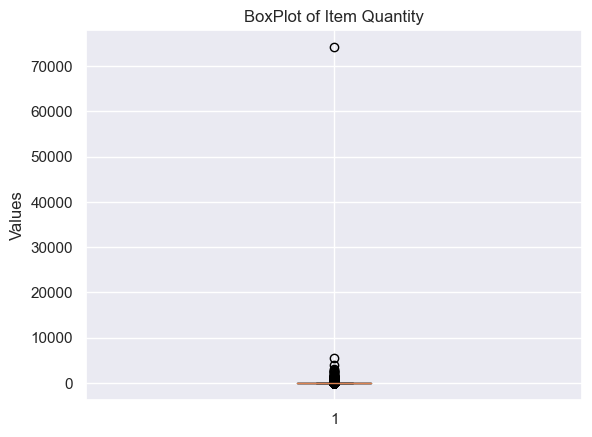

In [1245]:
# Checking data for outliers
'''In our data there is only one column with numeric values, let's check it'''
plt.boxplot(df_modified.quantity)
plt.ylabel('Values')
plt.title('BoxPlot of Item Quantity')
plt.show()

There are quite a lot of outliners found in the quantity column based on the observation of the boxplot graph. 

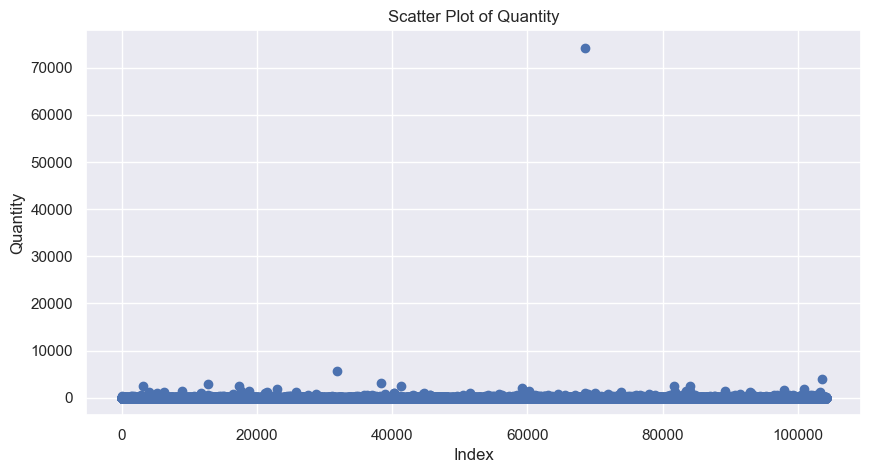

In [1246]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(range(len(df_modified)), df_modified['quantity'])
ax.set_title('Scatter Plot of Quantity')
ax.set_xlabel('Index')
ax.set_ylabel('Quantity')
plt.show()

We try to display the quantity data using a scatter plot, where the distribution is more visible, but we find outliers with quite striking values.

In [1247]:
df_modified.quantity.describe()

count    104151.000000
mean          9.700733
std         234.207369
min           1.000000
25%           2.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64

In [1248]:
# find outliers with Interquartile Range
columns = ['quantity']
outlier_percentage = {}

for column in columns:
    column_data = df_modified[column]

    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]
    outlier_percentage[column] = len(outliers) / len(column_data) * 100

# Display the outlier percentage for each column
for column, percentage in outlier_percentage.items():
    print(f"Count of outliers in column '{column}': {len(outliers)}")
    print(f"Percentage of outliers in column '{column}': {percentage:.2f}%")
    print()

Count of outliers in column 'quantity': 11616
Percentage of outliers in column 'quantity': 11.15%



There are 9831 data which are outliners. We decided to change the values of the outliners to the values of the upper and lower bounds, to preserve the number of samples.

In [1249]:
# define lower and upper bounds
columns = ['quantity']
lower_bounds, upper_bounds = [], []
for column in columns :
    lower_bound = retail_modified[column].describe()['25%'] - (1.5 * (retail_modified[column].describe()['75%'] -
                                                                          retail_modified[column].describe()['25%']))
    upper_bound = retail_modified[column].describe()['75%'] + (1.5 * (retail_modified[column].describe()['75%'] -
                                                                          retail_modified[column].describe()['25%']))
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

In [1250]:
# create new df with outliers replaced with upper bounds and lower bounds
new_df_modified = df_modified.copy()
for n, column in enumerate(columns):
    new_df_modified[column] = np.where(new_df_modified[column] < lower_bounds[n], lower_bounds[n], new_df_modified[column])
    new_df_modified[column] = np.where(new_df_modified[column] > upper_bounds[n], upper_bounds[n], new_df_modified[column])

The outliner has been successfully changed to upper/lower bounds and after checking again, no outliers were found.

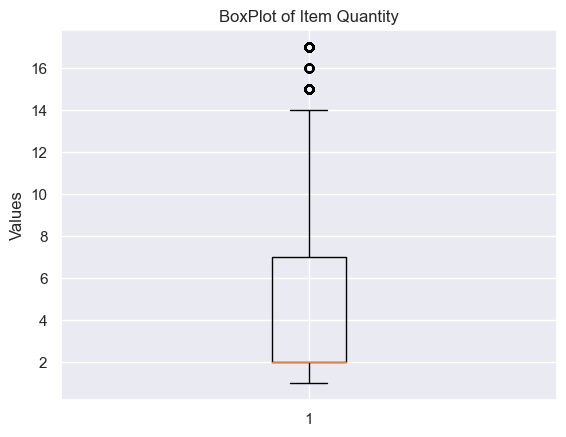

In [1251]:
# Checking data for outliers
'''In our data there is only one column with numeric values, let's check it'''
plt.boxplot(new_df_modified.quantity)
plt.ylabel('Values')
plt.title('BoxPlot of Item Quantity')
plt.show()

In [1252]:
new_df_modified.duplicated().sum()

16

In [1253]:
new_df_modified = new_df_modified.drop_duplicates()
new_df_modified.duplicated().sum()

0

In [1254]:
# Number of Purchases per Day
purchases_by_day = new_df_modified.groupby(new_df_modified['purchase_date'].dt.date).size()
purchases_by_day

purchase_date
2016-12-01    3049
2016-12-02    2064
2016-12-03    2183
2016-12-05    2606
2016-12-06    3826
              ... 
2017-02-23    1574
2017-02-24    1289
2017-02-25     977
2017-02-27     782
2017-02-28    1716
Length: 68, dtype: int64

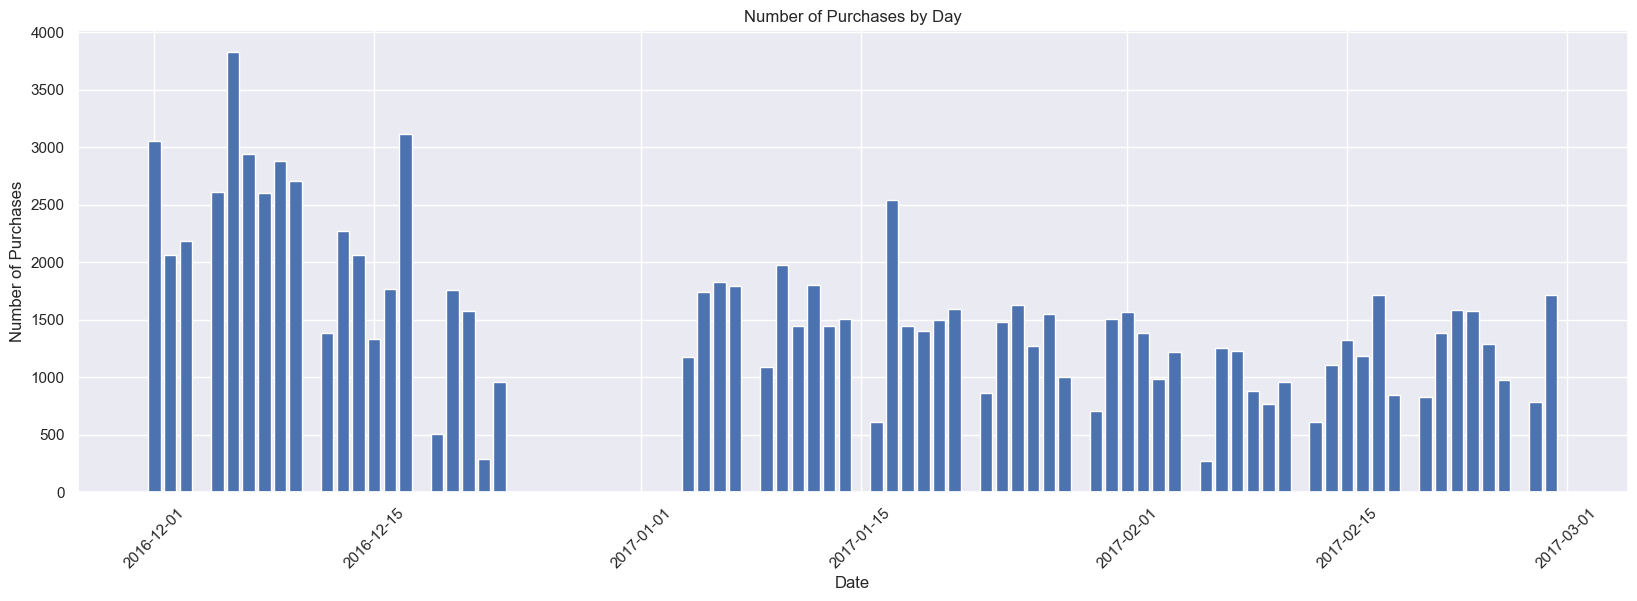

In [1255]:
plt.figure(figsize=(20, 6))
plt.bar(purchases_by_day.index, purchases_by_day.values)
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases by Day')
plt.xticks(rotation=45)
plt.show()

In [1256]:
# Calculate the minimum and maximum purchase_date
min_purchase_date= new_df_modified['purchase_date'].min()
max_purchase_date= new_df_modified['purchase_date'].max()

print("Minimum purchase date:", min_purchase_date)
print("Maximum purchase date:", max_purchase_date)

Minimum purchase date: 2016-12-01 08:26:00
Maximum purchase date: 2017-02-28 17:04:00


* This dataset contains retail data from 1 December 2016 to 28 February 2017 or 3 months.
* Transactions do not occur every day, especially from the end of December to January 1. There may be no transactions due to the year-end holiday.
* The highest transaction was at the beginning of December, after that the transaction rose and fell but never exceeded the highest transaction in December.

In [1257]:
transactions_per_date= new_df_modified.groupby(
                  ['purchase_date', 'loyalty_program']).size().reset_index(
                  name='Transaction Count')
transactions_per_date

,purchase_date,loyalty_program,Transaction Count
0,2016-12-01 08:26:00,1.0,7
1,2016-12-01 08:28:00,1.0,2
2,2016-12-01 08:34:00,0.0,16
3,2016-12-01 08:35:00,0.0,1
4,2016-12-01 08:45:00,0.0,20
...,...,...,...
4556,2017-02-28 16:47:00,0.0,225
4557,2017-02-28 16:50:00,0.0,179
4558,2017-02-28 16:59:00,0.0,167
4559,2017-02-28 17:01:00,1.0,14


In [1258]:
# Calculate the number of transactions per date with loyalty_program
transactions_per_date = new_df_modified.groupby(
                  ['purchase_date', 'loyalty_program']).size().reset_index(
                  name='Transaction Count')

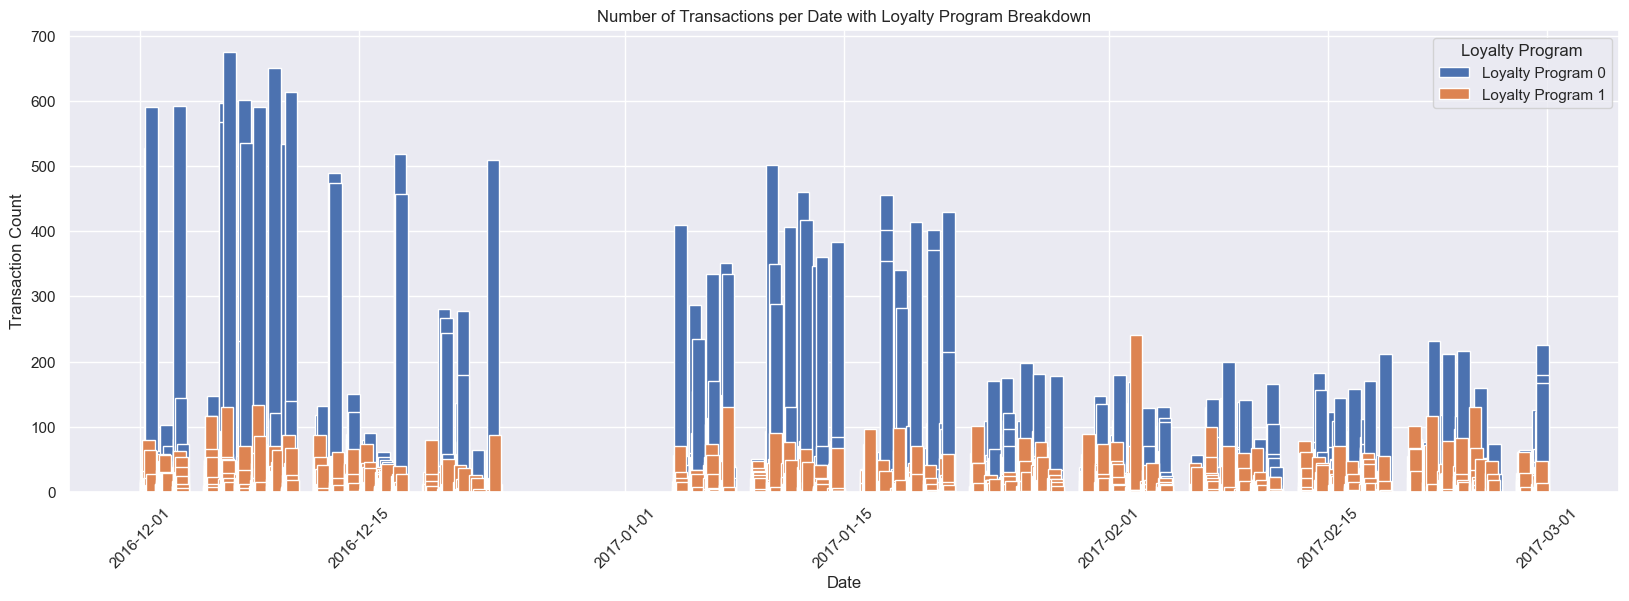

In [1259]:
# Create a new DataFrame for each loyalty_program category
loyalty_program_0 = transactions_per_date[transactions_per_date[
                  'loyalty_program'] == 0]
loyalty_program_1 = transactions_per_date[transactions_per_date[
                  'loyalty_program'] == 1]

plt.figure(figsize=(20, 6))

# Plot the transactions for loyalty_program 
plt.bar(loyalty_program_0['purchase_date'], loyalty_program_0[
                    'Transaction Count'], label='Loyalty Program 0')
plt.bar(loyalty_program_1['purchase_date'], loyalty_program_1[
                    'Transaction Count'], label='Loyalty Program 1')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Number of Transactions per Date with Loyalty Program Breakdown')

plt.xticks(rotation=45)

plt.legend(title='Loyalty Program')
plt.show()

Based on transaction data, only a small portion of transactions are made by customers who have a loyalty program.
Customers without a loyalty program are always larger than customer transactions with a non-loyalty program except for the beginning of February.


In [1260]:
new_df_modified.dtypes

purchase_id                object
item_id                    object
quantity                  float64
purchase_date      datetime64[ns]
customer_id                object
shop_id                    object
loyalty_program           float64
price_per_one             float64
dtype: object

In [1261]:
# Number of Customers
'''Calculate the total number of users, 
the number of loyal and non-loyal users, 
and the number of users by shop'''

# Exclude rows with customer_id = 0
filtered_data = new_df_modified[new_df_modified['customer_id']!= "0.0"]
total_users= filtered_data['customer_id'].nunique()

print('Total number of users:', total_users)

Total number of users: 1749


In [1262]:
# Group by loyalty program and calculate the count of unique customer IDs
customer_count_by_loyalty_program = filtered_data.groupby(
                'loyalty_program')['customer_id'].nunique().reset_index()

# Calculate the percentage contribution of each loyalty program category
customer_count_by_loyalty_program['%'] = (customer_count_by_loyalty_program
                ['customer_id'] / total_users) * 100

customer_count_by_loyalty_program

,loyalty_program,customer_id,%
0,0.0,1162,66.437965
1,1.0,587,33.562035


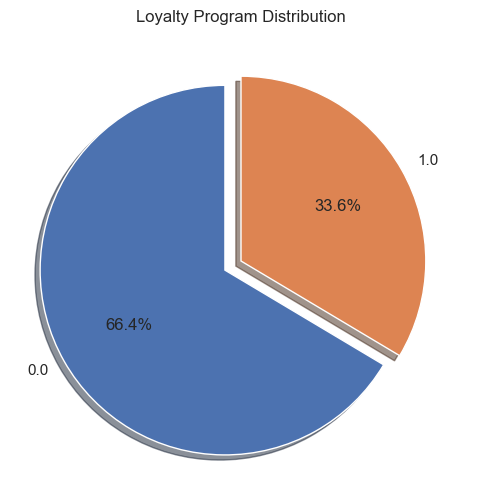

In [1263]:
# Create a pie chart
labels = customer_count_by_loyalty_program['loyalty_program']
sizes = customer_count_by_loyalty_program['%']
explode = (0.1, 0) 

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', 
            shadow=True, startangle=90)
plt.title('Loyalty Program Distribution')
sns.set()

plt.show()

Only 33.6% or 565 users joined program_loyalty. The majority of users have not used yet the loyalty program in their transactions.

In [1264]:
# Number of Purchases per Customer (Average Purchase)
'''Calculate the number of purchases per customer 
and the number of purchases per loyal and non-loyal customers.'''
number_purchases = len(new_df_modified)
number_unique_customers = new_df_modified["customer_id"].nunique()
average_purchase_per_customer = number_purchases/ number_unique_customers

print("Number of Purchases:", number_purchases)
print("Number of Unique Customers:", number_unique_customers)
print("Average Purchases per Customer:", round(average_purchase_per_customer,1))

Number of Purchases: 104135
Number of Unique Customers: 1750
Average Purchases per Customer: 59.5


In [1265]:
number_purchase_per_loyalty = new_df_modified.groupby('loyalty_program')['purchase_id'].count()
number_of_loyal_customers = new_df_modified[new_df_modified["loyalty_program"]== 1]["customer_id"].nunique()
number_customers_nonloyal= new_df_modified[new_df_modified["loyalty_program"]== 0]["customer_id"].nunique()

average_purchase_per_customer_loyal= number_purchase_per_loyalty[1] / number_of_loyal_customers
average_purchases_per_customer_nonloyal= number_purchase_per_loyalty[0] / number_customers_nonloyal

print("Number of Loyal Customers:", number_of_loyal_customers)
print("Number of Non-Loyal Customers:", number_customers_nonloyal)
print("Average Purchase per Loyal Customer:", round(average_purchase_per_customer_loyal, 1))
print("Average Purchase per Non-Loyal Customer:", round(average_purchases_per_customer_nonloyal, 1))

Number of Loyal Customers: 587
Number of Non-Loyal Customers: 1163
Average Purchase per Loyal Customer: 39.8
Average Purchase per Non-Loyal Customer: 69.5


There is a difference between the average purchase per customer between loyal and non-loyal customers. Loyal customers have an average of 40 purchases per customer, while non-loyal customers have an average of 70 purchases per customer. The average purchase per non-loyal customer is greater than the average purchase per loyal customer.

In [1266]:
# Purchases Size and Purchases Frequency
'''Average purchase based on the loyalty program and non-loyalty program'''
# Calculating average purchase size by loyalty program
loyal_customers = new_df_modified[new_df_modified['loyalty_program'] == 1]
average_quantity_loyal = loyal_customers['quantity'].mean()

non_loyal_customers = new_df_modified[new_df_modified['loyalty_program'] == 0]
average_quantity_non_loyal = non_loyal_customers['quantity'].mean()

print("Average Purchase Size for Loyalty Program Customers:", round(average_quantity_loyal,1))
print("Average Purchase Size for Non-Loyalty Program Customers:", round(average_quantity_non_loyal,1))

Average Purchase Size for Loyalty Program Customers: 5.5
Average Purchase Size for Non-Loyalty Program Customers: 5.1


In [1267]:
# Calculating frequency of purchases by loyalty program
loyal_customers_freq = new_df_modified[new_df_modified['loyalty_program']== 1].shape[0]
non_loyal_customers_freq = new_df_modified[new_df_modified['loyalty_program']== 0].shape[0]

print("Frequency of Purchases for Loyalty Program Customers:", loyal_customers_freq)
print("Frequency of Purchases for Non-Loyalty Program Customers:", non_loyal_customers_freq)

Frequency of Purchases for Loyalty Program Customers: 23347
Frequency of Purchases for Non-Loyalty Program Customers: 80788


The magnitude of customer transactions with the loyalty program is greater than the non-loyalty program, which is 5,6 and the non-loyal program is 5,1. While the frequency of purchase for the loyalty program is smaller than that of the non-loyalty program. With the loyalty program, it is 22912 and 79163 without the loyalty program.

In [1268]:
# Make correlation matrix
new_df_modified['total_sales'] = new_df_modified['price_per_one'] * new_df_modified['quantity']
new_df_modified.head()

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total_sales
0,538280,21873,11.0,2016-12-10 12:50:00,18427.0,Shop 0,0.0,3.36,36.96
1,538862,22195,2.0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,3.36,6.72
2,538855,21239,7.0,2016-12-14 13:50:00,22182.0,Shop 0,1.0,2.51,17.57
3,543543,22271,2.0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,5.91,11.82
4,543812,79321,2.0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,12.46,24.92


In [1269]:
corr_df = new_df_modified[['quantity', 'loyalty_program', 'price_per_one', 'total_sales']]

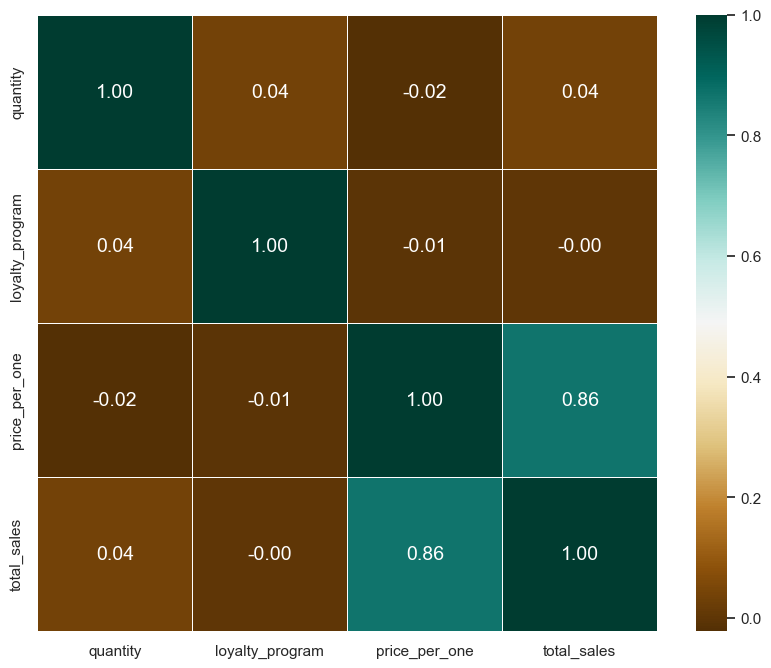

In [1270]:
corr_matrix= corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='0.2f', linewidths=0.5, 
                          cmap="BrBG", annot_kws={"fontsize": 14})
plt.show()

* There is a weak positive correlation between quantity and total sales (correlation coefficient of 0.06). This shows that the higher the quantity of goods purchased, the total sales tend to increase, although the relationship is not strong.
* There is a very weak positive correlation between the quantity and status of the loyalty program (correlation coefficient of 0.04). This shows that membership in a loyalty program has a very small effect on the quantity of goods purchased.
* Price per unit: There is a weak negative correlation between quantity and price per item (correlation coefficient of -0.03). This indicates that when the price per item increases, the quantity purchased tends to decrease, and vice versa.

## Hypothesis Test

Before carrying out the hypothesis test process, we check the distribution of the data, so that we can determine the right test method.

In [1271]:
columns_to_test= ['quantity', 'price_per_one', 'total_sales']

for column in columns_to_test:
    stat, p_value= st.shapiro(corr_df[column])
    alpha= 0.05

    print(f"Column: {column}")
    print(f"Shapiro-Wilk test statistic: {stat}")
    print(f"p-value: {p_value}")

    if p_value < alpha:
        print("The null hypothesis is rejected: the distribution is not normal.")
    else:
        print("Failure to reject the null hypothesis: the distribution looks normal")
       

Column: quantity
Shapiro-Wilk test statistic: 0.730291485786438
p-value: 0.0
The null hypothesis is rejected: the distribution is not normal.
Column: price_per_one
Shapiro-Wilk test statistic: 0.014110028743743896
p-value: 0.0
The null hypothesis is rejected: the distribution is not normal.
Column: total_sales
Shapiro-Wilk test statistic: 0.022585570812225342
p-value: 0.0
The null hypothesis is rejected: the distribution is not normal.


C:\Users\danyo\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


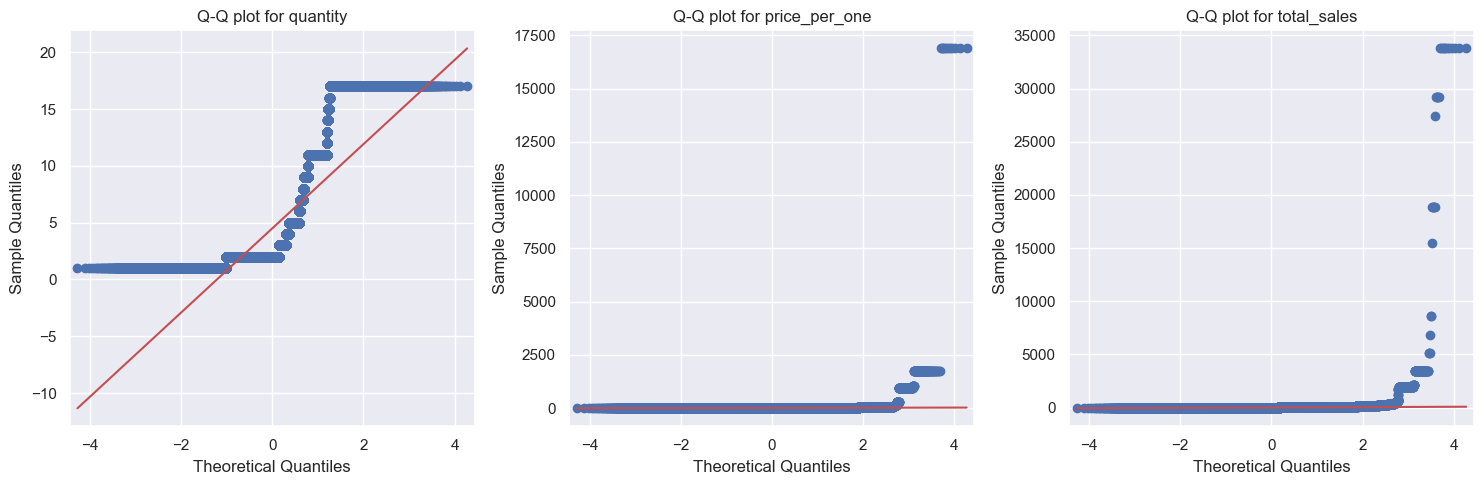

In [1272]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

# Q-Q plot for quantity
sm.qqplot(new_df_modified['quantity'], line ='q', ax=axes[0])
axes[0].set_title('Q-Q plot for quantity')

# Q-Q plot for price_per_one
sm.qqplot(new_df_modified['price_per_one'], line ='q', ax=axes[1])
axes[1].set_title('Q-Q plot for price_per_one')

# Q-Q plot for total_sales
sm.qqplot(new_df_modified['total_sales'], line ='q', ax=axes[2])
axes[2].set_title('Q-Q plot for total_sales')

plt.tight_layout()
plt.show()


To test the hypotheses let's take the Mann-Whitney U-test, because it is a nonparametric test, so it does not require the presence of normal distribution of the compared populations.

**Hypothesis statement :**

* Null hypothesis (H0): There is no significant difference between the number of items between the loyalty member group and the non-loyalty member group.
* Alternative hypothesis (H1): There is a significant difference between the number of items between the loyalty member group and the non-loyalty member group.

In [1273]:
# divide our customers into 2 groups - loyalty and non_loyalty members
loyalty_members= new_df_modified[new_df_modified['loyalty_program']== 1]
non_loyalty_members= new_df_modified[new_df_modified['loyalty_program']== 0]

# make the same samples of members
min_sample_size= min(len(loyalty_members), len(non_loyalty_members))
loyalty_members= loyalty_members.sample(n=min_sample_size, random_state=42)
non_loyalty_members= non_loyalty_members.sample(n=min_sample_size, random_state=42)

In [1274]:
from scipy.stats import mannwhitneyu
alpha= 0.05

# Conducting the Mann-Whitney test
statistic, p_value = mannwhitneyu(loyalty_members['quantity'], non_loyalty_members['quantity'])

print('Mann–Whitney U-test:')
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")
print()
if p_value < alpha:
    print("The null hypothesis is rejected")
else:
    print("There is not enough evidence to reject the null hypothesis")

Mann–Whitney U-test:
Statistic: 287020585.5
P-value: 1.047329884428723e-24

The null hypothesis is rejected


* Based on p-value, we can conclude that there is a significant difference between the purchase size of loyalty program members and non-loyalty members.
* We can reject the null hypothesis that the average purchase size is no significantly higher for loyalty program members than for non-members.

**Hypothesis statement:**

* Null hypothesis (H0): There is no significant difference in total sales between the loyalty member group and the non-loyalty member group.
* Alternative hypothesis (H1): There is a significant difference between total sales between the loyalty member group and the non-loyalty member group.

In [1275]:
# Conducting the Mann-Whitney test
statistic, p_value = mannwhitneyu(loyalty_members['total_sales'], non_loyalty_members['total_sales'])

print('Mann–Whitney U-test:')
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")
print()
if p_value < alpha:
    print("The null hypothesis is rejected")
else:
    print("There is not enough evidence to reject the null hypothesis")

Mann–Whitney U-test:
Statistic: 288274102.5
P-value: 3.29273366212733e-27

The null hypothesis is rejected


In this context, if the resulting p-value is smaller than the specified significance level, then we can reject the null hypothesis and accept the alternative hypothesis.
This will indicate that there is a significant difference in total sales between the loyalty member group and the non-loyalty member group.

## Cohort Analysis

A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves over time and compare it to other cohorts.

**Retention by Month**

A measurement method used to monitor and analyze the retention rate of users or customers in a product, service or platform over a specified period of time, measured in months.

In [1276]:
def get_month_start_date(x): return dt.datetime(x.year, x.month, 1).strftime("%Y-%m-%d")
new_df_modified['MonthStartDate'] = new_df_modified['purchase_date'].apply(get_month_start_date)
#new_df_modified['MonthStartDate'] = new_df_modified['purchase_date'].dt.month_name()
new_df_modified

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total_sales,MonthStartDate
0,538280,21873,11.0,2016-12-10 12:50:00,18427.0,Shop 0,0.0,3.36,36.96,2016-12-01
1,538862,22195,2.0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,3.36,6.72,2016-12-01
2,538855,21239,7.0,2016-12-14 13:50:00,22182.0,Shop 0,1.0,2.51,17.57,2016-12-01
3,543543,22271,2.0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,5.91,11.82,2017-02-01
4,543812,79321,2.0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,12.46,24.92,2017-02-01
...,...,...,...,...,...,...,...,...,...,...
104297,538566,21826,1.0,2016-12-13 11:21:00,0.0,Shop 0,0.0,2.51,2.51,2016-12-01
104298,540247,21742,2.0,2017-01-05 15:56:00,21143.0,Shop 0,0.0,12.72,25.44,2017-01-01
104299,538068,85048,1.0,2016-12-09 14:05:00,23657.0,Shop 0,1.0,16.98,16.98,2016-12-01
104300,538207,22818,11.0,2016-12-10 11:33:00,18427.0,Shop 0,0.0,0.85,9.35,2016-12-01


In [1277]:
#month_map = dict(zip(new_df_modified['MonthStartDate'].unique(), range(len(new_df_modified['MonthStartDate'].unique()))))
month_map = {'2017-01-01': 1, '2017-02-01': 2, '2016-12-01': 0}
new_df_modified['InvoiceMonthID'] = new_df_modified['MonthStartDate'].map(month_map)
new_df_modified['CohortMonthID'] = new_df_modified.groupby('customer_id')['InvoiceMonthID'].transform('min')
new_df_modified['CohortMonth'] = new_df_modified['CohortMonthID'].map(dict(zip(month_map.values(), month_map.keys())))
new_df_modified['CohortIndexMonth'] = new_df_modified['InvoiceMonthID'] - new_df_modified['CohortMonthID']

In [1278]:
print(new_df_modified.isna().any().any())

False


In [1279]:
new_df_modified

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,price_per_one,total_sales,MonthStartDate,InvoiceMonthID,CohortMonthID,CohortMonth,CohortIndexMonth
0,538280,21873,11.0,2016-12-10 12:50:00,18427.0,Shop 0,0.0,3.36,36.96,2016-12-01,0,0,2016-12-01,0
1,538862,22195,2.0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,3.36,6.72,2016-12-01,0,0,2016-12-01,0
2,538855,21239,7.0,2016-12-14 13:50:00,22182.0,Shop 0,1.0,2.51,17.57,2016-12-01,0,0,2016-12-01,0
3,543543,22271,2.0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,5.91,11.82,2017-02-01,2,2,2017-02-01,0
4,543812,79321,2.0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,12.46,24.92,2017-02-01,2,2,2017-02-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104297,538566,21826,1.0,2016-12-13 11:21:00,0.0,Shop 0,0.0,2.51,2.51,2016-12-01,0,0,2016-12-01,0
104298,540247,21742,2.0,2017-01-05 15:56:00,21143.0,Shop 0,0.0,12.72,25.44,2017-01-01,1,1,2017-01-01,0
104299,538068,85048,1.0,2016-12-09 14:05:00,23657.0,Shop 0,1.0,16.98,16.98,2016-12-01,0,0,2016-12-01,0
104300,538207,22818,11.0,2016-12-10 11:33:00,18427.0,Shop 0,0.0,0.85,9.35,2016-12-01,0,0,2016-12-01,0


In [1280]:
#Count monthly active customers from each cohort
grouping = new_df_modified.groupby(['CohortMonth', 'CohortIndexMonth'])
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndexMonth',values='customer_id')
cohort_counts

CohortIndexMonth,0,1,2
CohortMonth,,,
2016-12-01,949.0,363.0,318.0
2017-01-01,421.0,101.0,NaN
2017-02-01,380.0,NaN,NaN


In [1281]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) 
retention.round(3) * 100 

CohortIndexMonth,0,1,2
CohortMonth,,,
2016-12-01,100.0,38.3,33.5
2017-01-01,100.0,24.0,NaN
2017-02-01,100.0,NaN,NaN


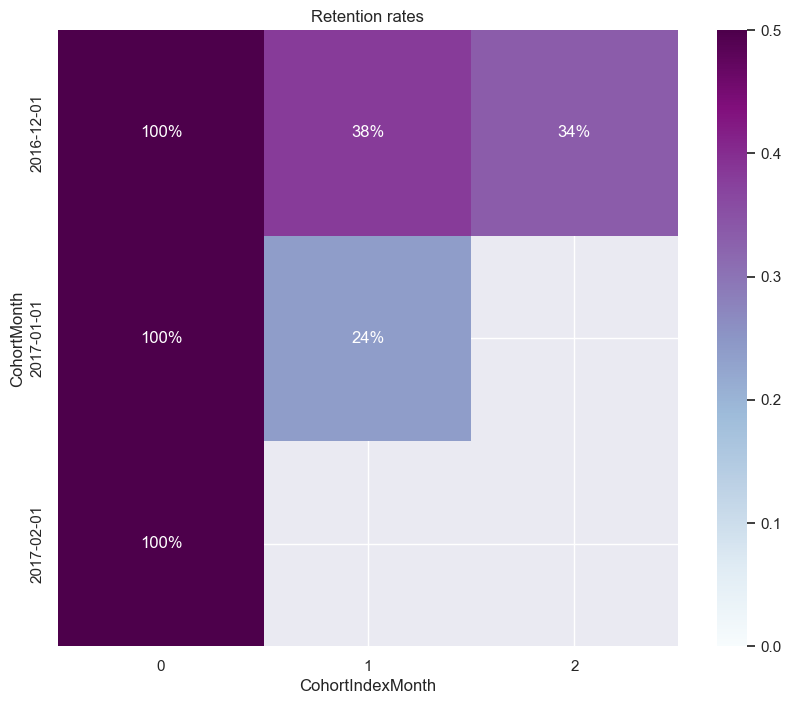

In [1282]:
#Build the heatmap
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu")
plt.show()

**Conclusion :**

Retention rate by month is quite small, in month 12 there are 886 users but only 32% in the second month and 37% in the second month.

Retention Rate in other months is even lower.

**Loyalty Retention Program**

A program designed and implemented by a company or organization with the aim of maintaining and strengthening long-term relationships with their customers or users. This program aims to increase customer loyalty, encourage users to stay engaged with products or services, as well as increase retention rates.

In [1283]:
loyal_program = new_df_modified[new_df_modified['loyalty_program'] == 1]
non_loyal_program = new_df_modified[new_df_modified['loyalty_program'] == 0]

In [1284]:
#Count monthly active customers from each cohort
grouping = loyal_program.groupby(['CohortMonth', 'CohortIndexMonth'])
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndexMonth',values='customer_id')
cohort_counts

CohortIndexMonth,0,1,2
CohortMonth,,,
2016-12-01,344.0,115.0,121.0
2017-01-01,124.0,30.0,NaN
2017-02-01,119.0,NaN,NaN


In [1285]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndexMonth,0,1,2
CohortMonth,,,
2016-12-01,100.0,33.4,35.2
2017-01-01,100.0,24.2,NaN
2017-02-01,100.0,NaN,NaN


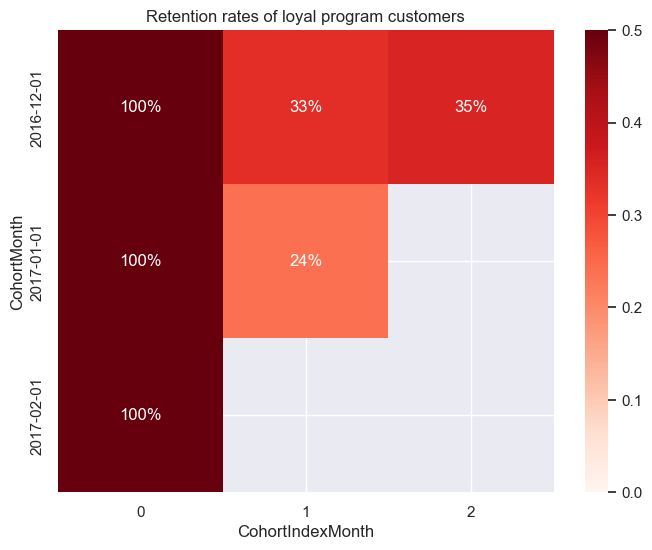

In [1286]:
#Build the heatmap
plt.figure(figsize=(8, 6))
plt.title('Retention rates of loyal program customers')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="Reds")
plt.show()

In [1287]:
#Count monthly active customers from each cohort
grouping = non_loyal_program.groupby(['CohortMonth', 'CohortIndexMonth'])
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndexMonth',values='customer_id')
cohort_counts

CohortIndexMonth,0,1,2
CohortMonth,,,
2016-12-01,605.0,248.0,197.0
2017-01-01,297.0,71.0,NaN
2017-02-01,261.0,NaN,NaN


In [1288]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndexMonth,0,1,2
CohortMonth,,,
2016-12-01,100.0,41.0,32.6
2017-01-01,100.0,23.9,NaN
2017-02-01,100.0,NaN,NaN


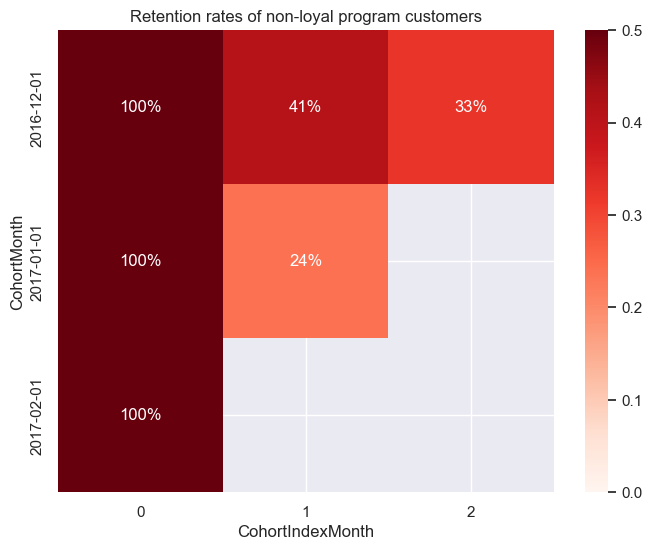

In [1289]:
#Build the heatmap
plt.figure(figsize=(8, 6))
plt.title('Retention rates of non-loyal program customers')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="Reds")
plt.show()

Conclusion :

Customer retention with a loyalty program does not show a better comparison than retention with users without a loyalty program.

Customer retention with a non-loyalty program is higher in the first month, namely 41% compared to users with a loyalty program, only 33% in the first month. Meanwhile, in the second month, users with a higher loyalty program were 35% and 33% without a loyalty program.

## Conclusion

* This dataset contains retail data from 1 December 2016 to 28 February 2017 or about 3 months. Transactions do not occur every day, especially from the end of December to January 1. There may be no transactions due to the year-end holiday. The highest transaction was at the beginning of December, after that the transaction rose and fell but never exceeded the highest transaction in December.

* Only 33.6% or 565 users join program_loyalty. The majority of users have not used the loyalty program in their transactions.

* There is a difference between the average purchase per customer between loyal and non-loyal customers. Loyal customers have an average of 41 purchases per customer, while non-loyal customers have an average of 71 purchases per customer. The average purchase per non-loyal customer is greater than the average purchase per loyal customer.

* Overall, this analysis shows that price per item has the strongest positive correlation with total sales, followed by quantity purchased. However, the correlation between loyalty program status and total sales is very small.

* Customer retention with a loyalty program does not show a better comparison than retention with users without a loyalty program. Customer retention without a loyalty program is higher in the first month, namely 41% compared to users with a loyalty program, only 33% in the first month. Whereas in the second month users with a higher loyalty program were 35% and 33% without a loyalty program.

* Based on the very small p-value (smaller than the specified level of significance), we can conclude that there is a significant difference between the purchase size of loyalty program members and non-members. We can reject the null hypothesis that there is no significant difference and accept the alternative hypothesis that the average purchase size is significantly higher for loyalty program members than for nonmembers. Based on the results of statistical tests, we can conclude that loyalty program members tend to have a significantly higher purchase size than non-members.

* Member fees per month, discount or other benefits need to be reviewed. This refers to purchases per loyal customer which are still smaller than non-loyal customers. Loyalty program customer retention also did not increase significantly compared to non-loyalty customer retention. If there is no improvement in the loyalty program benefits, it is likely that customers tend to choose transactions without a loyalty program.

In [1290]:
new_df_modified.to_csv('new_df_modified.csv')